In [17]:
import pandas as pd

In [18]:
df = pd.read_csv('/content/arabic_f.csv', encoding='UTF-8')
df

,y,text
0,0,بيونسيه تتضاعف لأول مرة أغنية أخرى لاستدراج عر...
1,1,مرض ماكين يحرم مجلس شيوخ تصويت حاسم اشنطن رويت...
2,0,تقرير تقول جماعات حقوق مدنية قمع ناخبين مسؤول ...
3,0,يروي عامل ديزني قصة مرعبة إجباره تدريب عامل أج...
4,1,بيت أبيض اشنطن رويترز قال بيت أبيض يوم ترامب ب...
...,...,...
42417,1,زير مالية ألماني فولفغانغ شيوبله يحذر ترامب حم...
42418,1,بورتو أورداز فنزويلا رويترز قالت سلطات فنزويلي...
42419,0,تمكن مكتب تحقيقات فيدرالي كشف مؤامرة إرهابية ي...
42420,1,خطة ضريبية تهدد منطقة برمودا ول ستريت نيويورك ...


In [19]:
df = df.dropna(subset=['text'])
print(df.isnull().sum())

y       0
text    0
dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

# df يحتوي عمود 'text' و 'label'
X = df['text']
y = df['y']

# 70% Train, 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# 15% Validation, 15% Test (نصف 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 29665
Validation: 6357
Test: 6357


# finished the part of the splite
## the next is the part of **TF-IDF** :

In [21]:
import re

def arabic_tokenizer(text):
    # الاحتفاظ بالحروف العربية فقط + الأعداد إذا أردت
    text = re.sub(r"[^ء-ي\s]+", " ", text)

    # حذف المسافات المتكررة
    text = re.sub(r"\s+", " ", text).strip()

    # تحويل النص إلى قائمة كلمات
    tokens = text.split()
    return tokens


from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    tokenizer=arabic_tokenizer,
    ngram_range=(1, 2),      # Unigrams + Bigrams
    max_features=7000,       # يمكن تغييره
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    lowercase=False          # مهم جداً لأن tokenizer يعتني بالأحرف
)

tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
fake_keywords = [
    "عاجل", "فضيحة", "كارثة", "تحذير", "خطير", "هام", "حصري",
    "لن تصدق", "شاهد", "صادم", "كشف", "تسريب", "خطير جدا"
]


In [23]:
import numpy as np
import string

def extract_linguistic_features(text):
    text = str(text)

    length = len(text)
    words = arabic_tokenizer(text)
    word_count = len(words)

    # علامات الترقيم
    punct_count = sum(1 for c in text if c in string.punctuation)
    punctuation_ratio = punct_count / (length + 1)

    # علامة التعجب
    exclamation_ratio = text.count("!") / (length + 1)

    # كلمات مثيرة (Fake-News Keywords)
    keyword_flag = any(kw in text for kw in fake_keywords)

    return [
        length,
        word_count,
        punctuation_ratio,
        exclamation_ratio,
        int(keyword_flag)
    ]


In [24]:
def build_linguistic_matrix(series):
    return np.array([extract_linguistic_features(t) for t in series])

X_train_ling = build_linguistic_matrix(X_train)
X_val_ling   = build_linguistic_matrix(X_val)
X_test_ling  = build_linguistic_matrix(X_test)


In [25]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity

    if polarity > 0.1:
        return [1, 0, 0]  # Positive
    elif polarity < -0.1:
        return [0, 0, 1]  # Negative
    else:
        return [0, 1, 0]  # Neutral


In [26]:
X_train_sent = np.array([get_sentiment(t) for t in X_train])
X_val_sent   = np.array([get_sentiment(t) for t in X_val])
X_test_sent  = np.array([get_sentiment(t) for t in X_test])


In [27]:
from scipy.sparse import hstack

X_train_full = hstack([X_train_tfidf, X_train_ling, X_train_sent])
X_val_full   = hstack([X_val_tfidf,   X_val_ling,   X_val_sent])
X_test_full  = hstack([X_test_tfidf,  X_test_ling,  X_test_sent])


In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.sparse import hstack


In [29]:
# class_weight='balanced' للتعامل مع عدم التوازن
model_lr = LogisticRegression(
    max_iter=300,
    class_weight='balanced',
    solver='liblinear',         # جيد للنماذج صغيرة/متوسطة الحجم
    random_state=42
)


In [30]:
model_lr.fit(X_train_full, y_train)


LogisticRegression(class_weight='balanced', max_iter=300, random_state=42,
                   solver='liblinear')

In [31]:
y_val_pred = model_lr.predict(X_val_full)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-score:", f1_score(y_val, y_val_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))




Validation Accuracy: 0.9861569922919616
Validation F1-score: 0.9861567425673188

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3176
           1       0.98      0.99      0.99      3181

    accuracy                           0.99      6357
   macro avg       0.99      0.99      0.99      6357
weighted avg       0.99      0.99      0.99      6357



In [32]:
y_test_pred = model_lr.predict(X_test_full)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-score:", f1_score(y_test, y_test_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.9877300613496932
Test F1-score: 0.9877299007298028

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3177
           1       0.98      0.99      0.99      3180

    accuracy                           0.99      6357
   macro avg       0.99      0.99      0.99      6357
weighted avg       0.99      0.99      0.99      6357



# =============================================================================
# =============================================================================

## ========================================

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

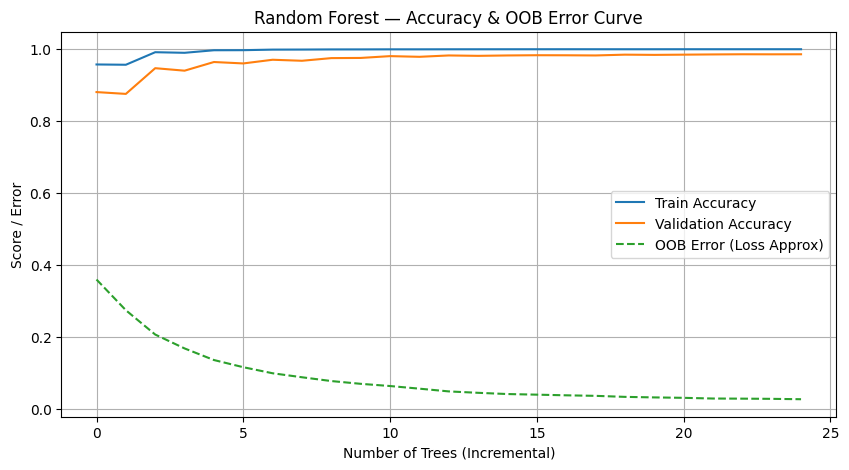

In [36]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# إعداد النموذج مع warm_start لتحديث عدد الأشجار تدريجيًا
model_rf = RandomForestClassifier(
    n_estimators=1,
    warm_start=True,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

max_trees = 25   # عدد المراحل (مثل epochs)
train_acc_list = []
val_acc_list = []
oob_error_list = []

for t in range(1, max_trees + 1):
    model_rf.n_estimators = t   # زيادة عدد الأشجار تدريجياً
    model_rf.fit(X_train_full, y_train)

    # accuracy
    train_acc = accuracy_score(y_train, model_rf.predict(X_train_full))
    val_acc = accuracy_score(y_val, model_rf.predict(X_val_full))

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # OOB error (بديل loss)
    if model_rf.oob_score_:
        oob_error_list.append(1 - model_rf.oob_score_)
    else:
        oob_error_list.append(None)

# --- الرسم ---

plt.figure(figsize=(10,5))

# accuracy curves
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')

# oob error curve = loss تقريباً
plt.plot(oob_error_list, label='OOB Error (Loss Approx)', linestyle='--')

plt.xlabel("Number of Trees (Incremental)")
plt.ylabel("Score / Error")
plt.title("Random Forest — Accuracy & OOB Error Curve")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
y_pred = model_rf.predict(X_test_full)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3177
           1       0.98      0.98      0.98      3180

    accuracy                           0.98      6357
   macro avg       0.98      0.98      0.98      6357
weighted avg       0.98      0.98      0.98      6357



/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

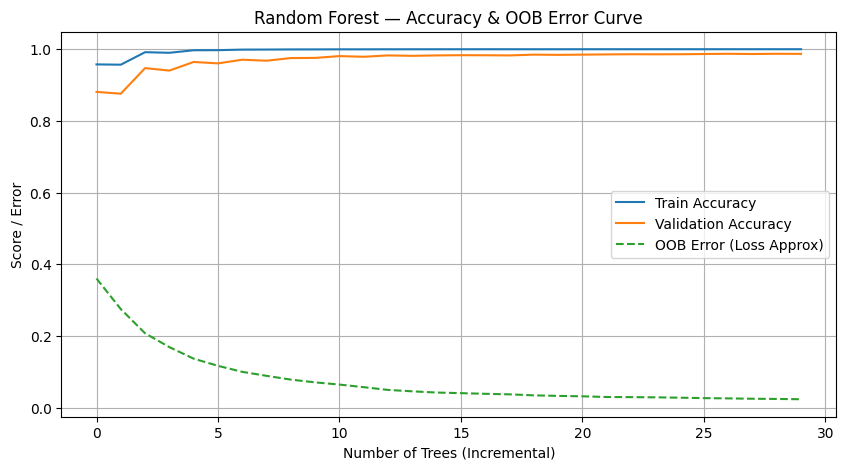

In [38]:
model_rf2 = RandomForestClassifier(
    n_estimators=1,
    warm_start=True,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

max_trees2 = 30   # عدد المراحل (مثل epochs)
train_acc_list = []
val_acc_list = []
oob_error_list = []

for t in range(1, max_trees2 + 1):
    model_rf2.n_estimators = t   # زيادة عدد الأشجار تدريجياً
    model_rf2.fit(X_train_full, y_train)

    # accuracy
    train_acc = accuracy_score(y_train, model_rf2.predict(X_train_full))
    val_acc = accuracy_score(y_val, model_rf2.predict(X_val_full))

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # OOB error (بديل loss)
    if model_rf2.oob_score_:
        oob_error_list.append(1 - model_rf2.oob_score_)
    else:
        oob_error_list.append(None)

# --- الرسم ---

plt.figure(figsize=(10,5))

# accuracy curves
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')

# oob error curve = loss تقريباً
plt.plot(oob_error_list, label='OOB Error (Loss Approx)', linestyle='--')

plt.xlabel("Number of Trees (Incremental)")
plt.ylabel("Score / Error")
plt.title("Random Forest — Accuracy & OOB Error Curve")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
y_pred = model_rf2.predict(X_test_full)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3177
           1       0.99      0.98      0.99      3180

    accuracy                           0.99      6357
   macro avg       0.99      0.99      0.99      6357
weighted avg       0.99      0.99      0.99      6357



In [41]:
import joblib
joblib.dump(model_rf2, "random_forest_model_arabic.pkl")

['random_forest_model_arabic.pkl']

NameError: name 'tfidf' is not defined